### Import packages

In [1]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
from rapidfuzz import process

### Import data

In [2]:
ccsr = pd.read_excel('Manual_Review/disease_hierarchy_12.18.2020.xlsx')

In [3]:
er = pd.read_csv('Comparing algorithms/er_rounds_3-6.csv')

In [26]:
er = pd.read_csv('Comparing algorithms/er_3-6_more_models.csv')

In [27]:
er = er[(er['ner_model'] == 'ner_jsl') & (er['er_model'] == 'sbiobertresolve_icd10cm_augmented')]

In [51]:
er = pd.read_csv('Comparing algorithms/elmo_spark_ner.csv')

In [52]:
er['entity_code'] = [x[2:-2] for x in er['ents']]

In [238]:
er = pd.read_csv('Comparing algorithms/er_3-6_new_jsl.csv')

In [356]:
er = pd.read_csv('Comparing algorithms/er_3-6_new_jsl_3.csv')

In [289]:
er = er[(er['ner_model'] == 'ner_jsl') & (er['er_model'] == 'sbiobertresolve_icd10cm_augmented')]

In [31]:
er = pd.read_csv('Comparing algorithms/ner_jsl_with_rules.csv')
er = er[['url','ner_chunk','codes']]
er = er.rename(columns={'codes':'entity_code'})

### Inspect data

In [4]:
ccsr.head()

,ICD-10-CM CODE,ICD-10-CM CODE DESCRIPTION,Level 3,Level 2,Level 1
0,I200,Unstable angina,Coronary atherosclerosis and other heart disease,Coronary artery disease,Cardiovascular diseases
1,I201,Angina pectoris with documented spasm,Coronary atherosclerosis and other heart disease,Coronary artery disease,Cardiovascular diseases
2,I208,Other forms of angina pectoris,Coronary atherosclerosis and other heart disease,Coronary artery disease,Cardiovascular diseases
3,I209,"Angina pectoris, unspecified",Coronary atherosclerosis and other heart disease,Coronary artery disease,Cardiovascular diseases
4,I2101,ST elevation (STEMI) myocardial infarction inv...,Acute myocardial infarction,Coronary artery disease,Cardiovascular diseases


In [18]:
er.head(5)

,url,ner_chunk,entity_code
0,https://www.gofundme.com/f/please-help-karens-...,lymphoma,C859
1,https://www.gofundme.com/f/patrickwalter,congenital heart defect,Q249
2,https://www.gofundme.com/f/gspdys,Oskaloosa,F488
3,https://www.gofundme.com/f/gspdys,infection,P399
4,https://www.gofundme.com/f/gspdys,infections,P399


In [28]:
urls = er['url'].unique().tolist()

In [49]:
url_toadd = []
ner_toadd = []
ent_toadd = []

for url in urls:
    if url in er['url'].unique():
        continue
    else:
        url_toadd.append(url)
        ner_toadd.append(np.nan)
        ent_toadd.append(np.nan)

In [48]:
len(ent_toadd)

0

In [50]:
er_df = pd.DataFrame({'url':url_toadd,'ner_chunk':ner_toadd,'entity_code':ent_toadd})

In [51]:
er = pd.concat([er, er_df])

In [52]:
er['url'].nunique()

200

### Define ER -> ICD10 mapping function

In [53]:
def AddCCSRInfo(er, ccsr):
    
    desc = []
    level_3 = []
    level_2 = []
    level_1 = []
    codes = {'old':[],'new':[]}
    
    er = er.fillna('NAN')
    
    for code in er['entity_code']:
        if code == 'NAN':
            desc.append(np.nan)
            level_3.append(np.nan)
            level_2.append(np.nan)
            level_1.append(np.nan)
            continue
            
        icd = ccsr[ccsr['ICD-10-CM CODE'] == code]
        
        if len(icd) > 0:
            icd = icd.values.tolist()[0]
            desc.append(icd[1])
            level_3.append(icd[2])
            level_2.append(icd[3])
            level_1.append(icd[4])
        else:
            if len(code) == 3:
                code_zero = code + '0'
                icd = ccsr[ccsr['ICD-10-CM CODE'] == code_zero]
                if len(icd) > 0:
                    icd = icd.values.tolist()[0]
                    desc.append(icd[1])
                    level_3.append(icd[2])
                    level_2.append(icd[3])
                    level_1.append(icd[4])
                else:
                    new_code = process.extractOne(code, ccsr['ICD-10-CM CODE'].tolist())[0]
                    codes['old'].append(code)
                    codes['new'].append(new_code)
                    icd = ccsr[ccsr['ICD-10-CM CODE'] == new_code].values.tolist()[0]
                    desc.append(icd[1])
                    level_3.append(icd[2])
                    level_2.append(icd[3])
                    level_1.append(icd[4])
            else:
                new_code = process.extractOne(code, ccsr['ICD-10-CM CODE'].tolist())[0]
                codes['old'].append(code)
                codes['new'].append(new_code)
                icd = ccsr[ccsr['ICD-10-CM CODE'] == new_code].values.tolist()[0]
                desc.append(icd[1])
                level_3.append(icd[2])
                level_2.append(icd[3])
                level_1.append(icd[4])
    
    df = pd.DataFrame({'desc':desc, 'level_3':level_3, 'level_2': level_2, 'level_1': level_1})
    er = er.reset_index()
    df = df.reset_index()
    r = pd.concat([er, df], axis=1)
    
    return r, pd.DataFrame(codes)

In [54]:
def GetCategories(er):
    cat = []
    dic = []
    for url in er['url'].unique():
        df = er[er['url'] == url]
        l = df[['level_1','confidence']].groupby('level_1').agg(['count','sum']).index.tolist()
        d = df[['level_1','confidence']].groupby('level_1').agg(['count','sum']).to_dict()
        cat.append(l)
        dic.append(d)
    return pd.DataFrame({'url':er['url'].unique(),'categories':cat,'categories_metadata':dic})

In [296]:
er['confidence'].describe()

count    656.000000
mean       0.608878
std        0.350318
min        0.058900
25%        0.263450
50%        0.577700
75%        0.988900
max        0.999300
Name: confidence, dtype: float64

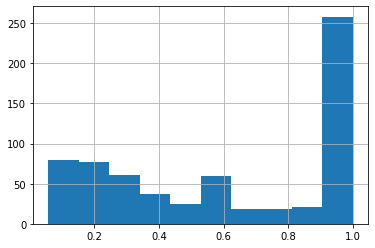

In [297]:
er['confidence'].hist()

In [55]:
er_with_ccsr, codes_log = AddCCSRInfo(er, ccsr) #takes ~1minute

In [56]:
er_with_ccsr['confidence'] = [1 for x in er_with_ccsr['url']]
er_with_ccsr = er_with_ccsr.fillna('Nonspecific')

In [57]:
categories = GetCategories(er_with_ccsr)

In [58]:
codes_log.head()

,old,new
0,C859,C8259
1,T781,T781XXA
2,G470,G4700
3,C5092,C50912
4,M4199,M419


### Format data for comparison with reference set

In [59]:
def list2lofd(df):
    '''convert cat column from comma delimited to list of dictionaries with 1 or 0 for each category'''
    
    disease_categories = [
        'Cardiovascular diseases',
        'Endocrine diseases',
        'Gastrointestinal diseases',
        'Genitourinary disorders',
        'Infections',
        'Injuries and external causes',
        'Mental, behavioral, and substance use disorders',
        'Musculoskeletal diseases',
        'Neoplasms',
        'Nervous system diseases',
        'Nonspecific',
        'Other noncommunicable diseases',
        'Pregnancy and childbirth',
        'Respiratory diseases'
    ]
    
    r = []
    
    for index,row in df.iterrows():
        lofd = []
        as_list = row['categories']
        for disease in disease_categories:
            if disease in as_list:
                lofd.append({disease:1})
            else:
                lofd.append({disease:0})
        r.append(lofd)
    return r

In [60]:
categories['lofd'] = list2lofd(categories)

In [61]:
#convert to long format
long = categories.explode('lofd')

In [62]:
#extract key, value from dictionary
long.insert(loc=2, column='cat', value=[list(x.items())[0][0] for x in long['lofd']])
long.insert(loc=3, column='count', value=[list(x.items())[0][1] for x in long['lofd']])

In [63]:
long = long[['url','cat','count']]

In [64]:
long = long.replace('Mental, behavioral, and substance use disorders', 'Mental and substance use disorders')

In [65]:
#create pivot tables
pivot = long.pivot_table(index=['url'], columns='cat', values='count', aggfunc=(pd.Series.sum), fill_value=0)

In [66]:
pivot.columns.name = ''
pivot = pivot.reset_index()

In [67]:
pivot.head()

,url,Cardiovascular diseases,Endocrine diseases,Gastrointestinal diseases,Genitourinary disorders,Infections,Injuries and external causes,Mental and substance use disorders,Musculoskeletal diseases,Neoplasms,Nervous system diseases,Nonspecific,Other noncommunicable diseases,Pregnancy and childbirth,Respiratory diseases
0,https://www.gofundme.com/f/1v3emdk740,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,https://www.gofundme.com/f/1xizs9mpo0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,https://www.gofundme.com/f/1zk33nyftc,0,0,0,0,0,1,1,0,0,0,1,0,0,0
3,https://www.gofundme.com/f/22efh5hg,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,https://www.gofundme.com/f/22kcir7teo,1,0,0,1,1,0,0,0,0,0,1,0,0,0


### Import reference data

In [68]:
ref = pd.read_csv('Manual_Review/reference_set/reference_set_any_pivot.csv')

In [69]:
ref.head()

,url,Cardiovascular diseases,Endocrine diseases,Gastrointestinal diseases,Genitourinary disorders,Infections,Injuries and external causes,Mental and substance use disorders,Musculoskeletal diseases,Neoplasms,Nervous system diseases,Nonspecific,Other noncommunicable diseases,Pregnancy and childbirth,Respiratory diseases
0,https://www.gofundme.com/f/1v3emdk740,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,https://www.gofundme.com/f/1xizs9mpo0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,https://www.gofundme.com/f/1zk33nyftc,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,https://www.gofundme.com/f/22efh5hg,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,https://www.gofundme.com/f/22kcir7teo,1,0,0,1,1,0,0,1,0,0,0,0,0,1


### Check that ER and reference urls are aligned

In [70]:
ref['url'].equals(pivot['url'])

False

In [71]:
ref[~ref['url'].isin(pivot['url'])]

,url,Cardiovascular diseases,Endocrine diseases,Gastrointestinal diseases,Genitourinary disorders,Infections,Injuries and external causes,Mental and substance use disorders,Musculoskeletal diseases,Neoplasms,Nervous system diseases,Nonspecific,Other noncommunicable diseases,Pregnancy and childbirth,Respiratory diseases
29,https://www.gofundme.com/f/Amarilindo,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [72]:
pivot[~pivot['url'].isin(ref['url'])]

,url,Cardiovascular diseases,Endocrine diseases,Gastrointestinal diseases,Genitourinary disorders,Infections,Injuries and external causes,Mental and substance use disorders,Musculoskeletal diseases,Neoplasms,Nervous system diseases,Nonspecific,Other noncommunicable diseases,Pregnancy and childbirth,Respiratory diseases
71,https://www.gofundme.com/f/esperanza-para-mi-v...,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [73]:
ref = ref[ref['url'].isin(pivot['url'])]
pivot = pivot[pivot['url'].isin(ref['url'])]

In [74]:
ref.shape

(199, 15)

In [75]:
pivot.shape

(199, 15)

In [76]:
ref = ref.reset_index()
pivot = pivot.reset_index()

In [77]:
ref['url'].equals(pivot['url'])

True

In [78]:
ref_urls = ref['url']

del ref['url']
del pivot['url']

In [79]:
del ref['index']
del pivot['index']

### Compute metrics

In [80]:
import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

In [81]:
from sklearn.metrics import classification_report

In [82]:
#calculated weighted average
#https://stackoverflow.com/questions/46732881/how-to-calculate-f1-score-for-multilabel-classification

y_true = []
y_pred = []
for col in pivot.columns:
    true = ref[col].tolist()
    pred = pivot[col].tolist()
    y_true.append(true)
    y_pred.append(pred)
    

In [83]:
print(precision_score(y_true=y_true, y_pred=y_pred, average='weighted'))
print(recall_score(y_true=y_true, y_pred=y_pred, average='weighted'))
print(f1_score(y_true=y_true, y_pred=y_pred, average='weighted'))

0.7478260869565218
0.6318840579710145
0.645667858711337


In [84]:
cat = []
precision = []
recall = []
f1 = []
acc = []
refe = []
piv = []
for col in pivot.columns:
    cat.append(col)
    precision.append(round(precision_score(ref[col], pivot[col]),2))
    recall.append(round(recall_score(ref[col], pivot[col]),2))
    f1.append(round(f1_score(ref[col], pivot[col]),2))
    acc.append(round(accuracy_score(ref[col], pivot[col]),2))
    refe.append(sum(ref[col]))
    piv.append(sum(pivot[col]))

In [85]:
df = pd.DataFrame({'category':cat, 
                   'ref_count':refe,
                   'test_count':piv,
              'precision':precision,
              'recall':recall,
             'f1':f1,
            'acc':acc})

In [86]:
df

,category,ref_count,test_count,precision,recall,f1,acc
0,Cardiovascular diseases,31,19,0.79,0.48,0.60,0.90
1,Endocrine diseases,12,10,0.60,0.50,0.55,0.95
2,Gastrointestinal diseases,9,4,0.50,0.22,0.31,0.95
3,Genitourinary disorders,21,9,0.89,0.38,0.53,0.93
4,Infections,16,15,0.67,0.62,0.65,0.94
5,Injuries and external causes,29,25,0.76,0.66,0.70,0.92
6,Mental and substance use disorders,17,14,0.71,0.59,0.65,0.94
7,Musculoskeletal diseases,19,13,0.92,0.63,0.75,0.96
8,Neoplasms,79,80,0.92,0.94,0.93,0.94
9,Nervous system diseases,36,23,0.91,0.58,0.71,0.91


In [87]:
df = df[~df['category'].isin(['Nonspecific','Pregnancy and childbirth','Other noncommunicable diseases'])]
print(np.average(df['precision'], weights=df['ref_count']/df['ref_count'].sum()))
print(np.average(df['recall'], weights=df['ref_count']/df['ref_count'].sum()))
print(np.average(df['f1'], weights=df['ref_count']/df['ref_count'].sum()))
print(np.average(df['acc'], weights=df['ref_count']/df['ref_count'].sum()))

0.8316842105263157
0.6526315789473683
0.7199649122807018
0.9322807017543859


# Predicting primary campaign

In [299]:
top = pd.read_csv('Manual_Review/reference_set/reference_set_top.csv')[['url','label']]

In [291]:
from collections import Counter
r = []
for url in er_with_ccsr['url'].unique():
    sub = er_with_ccsr[er_with_ccsr['url'] == url][['level_1','sentence']].sort_values('sentence', ascending=True)
    cats = Counter(sub['level_1'])
    max_count = max(cats.values())
    max_cats = [x[0]for x in cats.items() if x[1] == max_count]
    for cat in sub['level_1']:
        if cat in max_cats:
            final_cat = cat
    r.append({'url':url,'cat':cat})      

In [297]:
er_top = pd.DataFrame(r).fillna('Nonspecific')

In [301]:
top_merge = pd.merge(top, er_top, on='url')

In [307]:
top_merge.tail(25)

,url,label,cat
174,https://www.gofundme.com/f/650z2eo,Endocrine diseases,Nonspecific
175,https://www.gofundme.com/f/gspdys,Cardiovascular diseases,Cardiovascular diseases
176,https://www.gofundme.com/f/supermancoltonsmit,Nervous system diseases,Infections
177,https://www.gofundme.com/f/cecilia039s-kick-ca...,Neoplasms,Neoplasms
178,https://www.gofundme.com/f/xny684,Endocrine diseases,Endocrine diseases
179,https://www.gofundme.com/f/quimioterapias-y-ra...,Neoplasms,Neoplasms
180,https://www.gofundme.com/f/please-help-debbie-...,Nonspecific,Nonspecific
181,https://www.gofundme.com/f/help-baby-roman-fig...,Cardiovascular diseases,Nervous system diseases
182,https://www.gofundme.com/f/help-for-ana039s-me...,Nervous system diseases,Nonspecific
183,https://www.gofundme.com/f/Mizmig,Genitourinary disorders,Nonspecific


In [304]:
accuracy_score(top_merge['label'],top_merge['cat'])

0.6130653266331658

In [314]:
er.head()

,url,fund_description,ner_model,doc_reconstruction,sent_embeddings,er_model,target_text,sentence,start_char,end_char,resolved_text,entity_code,confidence,distance
3437,https://www.gofundme.com/f/please-help-karens-...,Help save my daughter's health<br /><br />Imag...,ner_jsl,none,sbiobert_base_cased_mli,sbiobertresolve_icd10cm_augmented,infection,0.0,362.0,370.0,infection,P399,0.9972,0.0000
3438,https://www.gofundme.com/f/please-help-karens-...,Help save my daughter's health<br /><br />Imag...,ner_jsl,none,sbiobert_base_cased_mli,sbiobertresolve_icd10cm_augmented,"food allergies,",1.0,384.0,398.0,food allergy,T781,0.4201,4.1091
3439,https://www.gofundme.com/f/please-help-karens-...,Help save my daughter's health<br /><br />Imag...,ner_jsl,none,sbiobert_base_cased_mli,sbiobertresolve_icd10cm_augmented,mental illness.,2.0,424.0,438.0,mental illness,F99,0.7708,2.6044
3440,https://www.gofundme.com/f/please-help-karens-...,Help save my daughter's health<br /><br />Imag...,ner_jsl,none,sbiobert_base_cased_mli,sbiobertresolve_icd10cm_augmented,infection,3.0,590.0,598.0,infection,P399,0.9972,0.0000
3441,https://www.gofundme.com/f/please-help-karens-...,Help save my daughter's health<br /><br />Imag...,ner_jsl,none,sbiobert_base_cased_mli,sbiobertresolve_icd10cm_augmented,mania,4.0,652.0,656.0,mania,F309,0.9914,0.0000
